In [1]:
import timeit

import matplotlib.pyplot as plt
from jax import jit, grad, vmap
from jax import numpy as jnp
from jax.scipy.optimize import minimize
from jax import value_and_grad
from jax.lax import scan

import numpy as np
from jax.scipy.linalg import expm
from scipy.signal import gaussian

from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import dispatch
from qiskit_dynamics.dispatch import Array
from qiskit_dynamics.models import HamiltonianModel
from qiskit_dynamics import Signal, DiscreteSignal, solve_lmde

from jax.config import config
config.update("jax_enable_x64", True)
dispatch.set_default_backend('jax')

from qiskit_dynamics_internal.perturbation import solve_lmde_perturbation
from discrete_signals import get_param_to_signal
from objectives import get_grape_fidelity_func

Z = Array([[1., 0.], [0., -1.]], dtype=complex)
X = Array([[0., 1.], [1., 0.]], dtype=complex)
Y = Array([[0., -1j], [1j, 0.]], dtype=complex)

tol = 1e-8

/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/dispatch/array.py:20: DeprecationWarning: Importing Array from `qiskit_dynamics.dispatch` is deprecated and will be removed next release. Import from `qiskit_dynamics.array` instead.
  warnings.warn(


# 1. In the presence of 2 perturbations, demonstrate approximating fidelity with Magnus terms

Here we set up a duffing oscillator model in the rotating frame of an on-resonance drive frequency, after the RWA:
\begin{equation}
    H(t) = 2\pi\delta_0 a^\dagger a+\pi \alpha a^\dagger a (a^\dagger a - 1) + 2 \pi r(1+\delta_1)[ c_x(t) (a + a^\dagger) + c_y(t) i(a - a^\dagger)].
\end{equation}
where
- $\delta_0$ is the difference between the qubit frequency and drive frequency
-$\delta_1$ is similar to a variation in transfer function
- $\alpha$ is the anharmonicity
- $r$ is the drive strength, and
- $c_x(t)$ and $c_y(t)$ are the x and y control fields

In [2]:
#setting

dim = 4 # dimension cutoff for oscillators

# truncated annihilation, creation, and number operators
a = jnp.diag(np.sqrt(np.arange(1, dim, dtype=complex)), -1)
adag = a.conj().transpose()
numb = jnp.diag(np.arange(dim, dtype=complex))

# truncated oscillator X and Y
osc_X = a + adag
osc_Y = 1j*(a-adag)


# model parameters - work in units of GHz/ns
anharm = -0.33
drive_strength = 0.02

# drift Hamiltonian on resonance
H0 = Array(np.pi * anharm * numb * (numb - jnp.eye(dim)))

# control terms - X and Y multiplied by 2 pi * drive_strength
Hc = Array(2 * np.pi * drive_strength * jnp.array([osc_X, osc_Y]))
perturb = Array(-1j*2*np.pi*numb) #the 0th perturbation

Utarget = X

Alist = -1j * Hc
D = -1j * H0

dt_filter = 0.125

#get fidelity function
fid_func = get_grape_fidelity_func(X)

# helper function for 2D meshplots
def cell_centered(arr_in):
    arr_out = np.empty(len(arr_in)+1)
    dist = arr_in[1] - arr_in[0]
    for i in range(len(arr_in)):
        arr_out[i] = arr_in[i] - dist/2
    arr_out[-1] = arr_in[-1] + dist/2
    return arr_out

## 1.1 Set up signal parameterization

Here we use discretized legendre polynomials up to a given order `leg_order` for a given number of time steps `N`, which are then filtered to be smooth. This is contained in the `get_param_to_signal` function, which we should explain in detail.

In [3]:
# choose the size of the legendre basis
leg_order = 4
# choose # steps of the signal
N = 25

#randomly generate a signal in the legendre basis
param = jnp.array(np.random.rand(2,leg_order + 1))

#Convert the signal from legendre basis to time series

#get the filter
param_to_signal = get_param_to_signal(leg_order, N)
#get the signal
signal = param_to_signal(param)
signal1 = signal[:,0]
signal2 = signal[:,1]

T = dt_filter*len(signal1) #28.125 for (4,25)

pc1 = DiscreteSignal(dt=dt_filter, samples=signal1,carrier_freq=0.)
pc2 = DiscreteSignal(dt=dt_filter, samples=signal2,carrier_freq=0.)
operators = [H0, Hc[0], Hc[1], 1j*perturb]
hamiltonian = HamiltonianModel(operators=Array(operators))

def G(t):#the generator
    c1 = pc1(t)
    c2 = pc2(t)
    return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

#the 1st perturbation
def A0(t):
    return perturb

# the 2nd perturbation - transfer function variation
def A1(t):
    c1 = pc1(t)
    c2 = pc2(t)
    return -1j*(c1*Hc[0] + c2*Hc[1])

In [4]:
ham = hamiltonian.copy()
ham.signals = [1., pc1, pc2, 0.]

results = solve_lmde_perturbation(A_list=[A0, A1], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=5,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=ham, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=1e-13, # standard solver arguments
                             atol=1e-13)

/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/dispatch/array.py:20: DeprecationWarning: Importing Array from `qiskit_dynamics.dispatch` is deprecated and will be removed next release. Import from `qiskit_dynamics.array` instead.
  warnings.warn(


Extract final unitary and construct polynomials for various orders.

In [5]:
U = results.y[-1]

from qiskit_dynamics_internal.perturbation.power_series_utils import MatrixPolynomial

term_labels = results.perturbation_results.term_labels
perturbation_terms = results.perturbation_results.perturbation_terms

# second order polynomial
n_terms = list(map(lambda x: len(x) <= 2, term_labels)).count(True)
magnus_poly2 = MatrixPolynomial(perturbation_terms[:n_terms, -1],
                                monomial_multisets=term_labels[:n_terms])

# third order polynomial
n_terms = list(map(lambda x: len(x) <= 3, term_labels)).count(True)
magnus_poly3 = MatrixPolynomial(perturbation_terms[:n_terms, -1],
                                monomial_multisets=term_labels[:n_terms])

# fourth order polynomial
n_terms = list(map(lambda x: len(x) <= 4, term_labels)).count(True)
magnus_poly4 = MatrixPolynomial(perturbation_terms[:n_terms, -1],
                                monomial_multisets=term_labels[:n_terms])

# fifth order polynomial
n_terms = list(map(lambda x: len(x) <= 5, term_labels)).count(True)
magnus_poly5 = MatrixPolynomial(perturbation_terms[:n_terms, -1],
                                monomial_multisets=term_labels[:n_terms])

magnus_polynomials = [magnus_poly2, magnus_poly3, magnus_poly4, magnus_poly5]

Compute error estimates over a range of values of $c1$ and $c2$ using the Magnus approximation.

In [6]:
# get the 2nd to 5th order approximate error rates using the Magnus terms
def err_est(c1, c2, order):
    
    coeffs = jnp.array([c1, c2])
    
    U_approx = U @ expm(magnus_polynomials[order - 2](coeffs).data)
    
    fid = fid_func(U_approx)
    return 1. - fid 

z_vals = jnp.linspace(-1.5*drive_strength, 1.5*drive_strength, 20)
v_vals = jnp.linspace(-0.2, 0.2, len(z_vals))
err_estimate2 = [err_est(z,v,2) for v in v_vals for z in z_vals]
err_estimate3 = [err_est(z,v,3) for v in v_vals for z in z_vals]
err_estimate4 = [err_est(z,v,4) for v in v_vals for z in z_vals]
err_estimate5 = [err_est(z,v,5) for v in v_vals for z in z_vals]

Compute error via direct simulation.

In [7]:
#exact error with the two perturbations
def exact_err(args):
    c1,c2 = args
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal1,carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal2,carrier_freq=0.)
    signals2 = [1., pc1_, pc2_, Array(c1)]
    ham_copy = hamiltonian.copy()
    ham_copy.signals = signals2
    time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
    return 1.-fid_func(time_results.y[-1]).data

err_exact = vmap(exact_err)((jnp.tile(z_vals,len(v_vals)),jnp.repeat(v_vals,len(z_vals))))

Plot the difference.

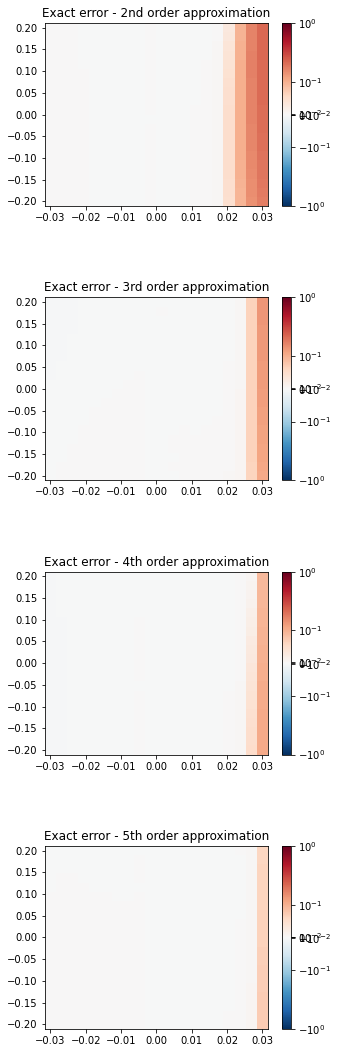

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

#plot the differences between estimates and exact error
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
diff2 = jnp.array(err_estimate2) - err_exact
diff3 = jnp.array(err_estimate3) - err_exact
diff4 = jnp.array(err_estimate4) - err_exact
diff5 = jnp.array(err_estimate5) - err_exact

x_cell = cell_centered(z_vals)
y_cell = cell_centered(v_vals)

#im0 = ax0.pcolormesh(z_vals, v_vals, err_exact.reshape(len(z_vals),len(v_vals)))
im1 = ax1.pcolormesh(x_cell, y_cell, diff2.reshape(len(z_vals),len(v_vals)),
                     norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im2 = ax2.pcolormesh(x_cell, y_cell, diff3.reshape(len(z_vals),len(v_vals)),
                     norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im3 = ax3.pcolormesh(x_cell, y_cell, diff4.reshape(len(z_vals),len(v_vals)),
                     norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im4 = ax4.pcolormesh(x_cell, y_cell, diff5.reshape(len(z_vals),len(v_vals)),
                     norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
#ax0.title.set_text('Exact error')
ax1.title.set_text('Exact error - 2nd order approximation')
ax2.title.set_text('Exact error - 3rd order approximation')
ax3.title.set_text('Exact error - 4th order approximation')
ax4.title.set_text('Exact error - 5th order approximation')
#fig.colorbar(im0, ax=ax0)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
fig.colorbar(im4, ax=ax4)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
fig.set_size_inches(5, 18.5) #change these numbers to adjust the plots
plt.show()

Text(0, 0.5, 'Error')

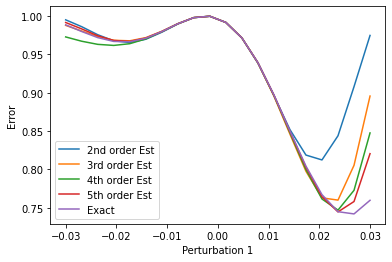

In [9]:
#Plot the diagonal of the 2D plot above
dia_err_exact = [err_exact.reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err2 = [jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err3 = [jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err4 = [jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err5 = [jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]

plt.plot(z_vals, dia_err2,label='2nd order Est')
plt.plot(z_vals, dia_err3,label='3rd order Est')
plt.plot(z_vals, dia_err4,label='4th order Est')
plt.plot(z_vals, dia_err5,label='5th order Est')
plt.plot(z_vals, dia_err_exact,label='Exact')
plt.legend()
plt.xlabel('Perturbation 1')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

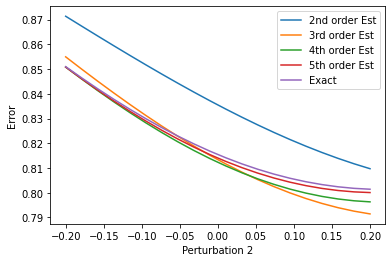

In [10]:
#Plot variation along vertical
col = 15
dia_err_exact = [err_exact.reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]
dia_err2 = [jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]
dia_err3 = [jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]
dia_err4 = [jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]
dia_err5 = [jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals))[i,col] for i in range(len(z_vals))]

plt.plot(v_vals, dia_err2,label='2nd order Est')
plt.plot(v_vals, dia_err3,label='3rd order Est')
plt.plot(v_vals, dia_err4,label='4th order Est')
plt.plot(v_vals, dia_err5,label='5th order Est')
plt.plot(v_vals, dia_err_exact,label='Exact')
plt.legend()
plt.xlabel('Perturbation 2')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

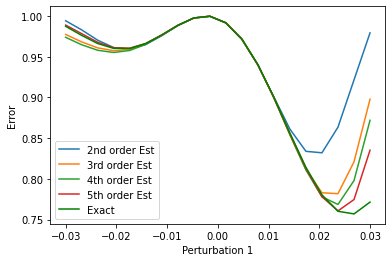

In [11]:
#Plot variation along horizontal
row = 10
dia_err_exact = [err_exact.reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]
dia_err2 = [jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]
dia_err3 = [jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]
dia_err4 = [jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]
dia_err5 = [jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals))[row,i] for i in range(len(z_vals))]

plt.plot(z_vals, dia_err2,label='2nd order Est')
plt.plot(z_vals, dia_err3,label='3rd order Est')
plt.plot(z_vals, dia_err4,label='4th order Est')
plt.plot(z_vals, dia_err5,label='5th order Est')
plt.plot(z_vals, dia_err_exact,color='g',label='Exact')
plt.legend()
plt.xlabel('Perturbation 1')
plt.ylabel('Error')

# 2. Scaling in number of parameters

The 2d plots above are nice for visualizing how increasing order helps. This next section demonstrates how the cost of this approach scales with the number of perturbations, for a fixed magnus order, as compared to direct simulation over a grid of points.

For each perturbation, we will consider $5$ sample points along its axis. Hence, $n$ parameters, we will be aggregating estimates of the fidelity at $5^n$ points. At $n=7$ we have $5^7 = 78125$ points.

We will do this at third order Magnus. Should we do higher order?

In [12]:
magnus_order = 4

#random inputs
inputs = jnp.array(np.random.rand(10, 2, leg_order + 1))

# drift Hamiltonian on resonance
H0 = Array(np.pi * anharm * numb * (numb - jnp.eye(dim)))

# control terms - X and Y multiplied by 2 pi * drive_strength
Hc = Array(2 * np.pi * drive_strength * jnp.array([osc_X, osc_Y]))
perturb0 = Array(-1j * 2 * np.pi * numb)
#perturb1 = -1j*(c1*Hc[0] + c2*Hc[1])
perturb2 = Array(-1j * np.pi * numb * (numb - jnp.eye(dim)))
perturb3 = Array(-1j * 2 * np.pi * osc_X)
perturb4 = Array(-1j * 2 * np.pi * osc_Y)
#perturb5 = -1j*(c1**2*Hc[0])   #c**2 * (a + adag)
perturb6 = Array(-1j * np.pi * anharm * numb * (numb - jnp.eye(dim)) * (numb - 2 * jnp.eye(dim)))

# 1. resonant frequency uncertainty * perturb0
# 2. anharmonicity uncertainty * perturb2
# 3. drive strength uncertainty 1 * perturb3
# 4. drive strength uncertainty 2 (or, amplitude/phase) * perturb4
# 5. c**2 * (a + adag) or c * (a + adag)**2 * 
# 6. anharmonicity of higher levels, uncertainty in drive strength between different levels *

/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/dispatch/array.py:20: DeprecationWarning: Importing Array from `qiskit_dynamics.dispatch` is deprecated and will be removed next release. Import from `qiskit_dynamics.array` instead.
  warnings.warn(


In [31]:
n_samples = 5
gaussian1 = jnp.array(gaussian(n_samples, n_samples/5))
gaussian1 /= jnp.sum(gaussian1) #normalize the distribution
gaussian2 = jnp.kron(gaussian1,gaussian1)
gaussian3 = jnp.kron(gaussian2,gaussian1)
gaussian4 = jnp.kron(gaussian3,gaussian1)
gaussian5 = jnp.kron(gaussian4,gaussian1)
gaussian6 = jnp.kron(gaussian5,gaussian1)
gaussian7 = jnp.kron(gaussian6,gaussian1)


#objective function defined with the approximate fid curve, 1 variation
def magnus_obj0(param1, p0_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])
    
    results = solve_lmde_perturbation(A_list=[A0], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=magnus_order,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G_, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
    U = results.y[-1]
    #symmetric Magnus polynomial
    perturb_terms = results.perturbation_results.perturbation_terms[:, -1]
    term_labels = results.perturbation_results.term_labels
    magnus_polynomial = MatrixPolynomial(matrix_coefficients=perturb_terms,
                                         monomial_multisets=term_labels)
    def err_est(args):
        coeffs = jnp.array([args])
        U_approx = U @ expm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data
    
    err_estimate = vmap(err_est)(p0_vals)
    return Array(jnp.sum(err_estimate * gaussian1)).data

#objective function defined with the approximate fid curve, 2 variations
def magnus_obj1(param1, p0_vals, p1_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt= dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])
    
    results = solve_lmde_perturbation(A_list=[A0, A1_], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=magnus_order,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G_, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
    U = results.y[-1]
        #symmetric Magnus polynomial
    perturb_terms = results.perturbation_results.perturbation_terms[:, -1]
    term_labels = results.perturbation_results.term_labels
    magnus_polynomial = MatrixPolynomial(matrix_coefficients=perturb_terms,
                                         monomial_multisets=term_labels)
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ expm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = np.kron(p0_vals, np.ones(5))
    p1_repeated = np.kron(np.ones(5), p1_vals)
    err_estimate = vmap(err_est)((p0_repeated ,p1_repeated))
    return Array(jnp.sum(err_estimate * gaussian2)) .data

#objective function defined with the approximate fid curve, 3 variations
def magnus_obj2(param1, p0_vals, p1_vals, p2_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2
    
    results = solve_lmde_perturbation(A_list=[A0, A1_, A2_], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=magnus_order,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G_, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
    U = results.y[-1]
        #symmetric Magnus polynomial
    perturb_terms = results.perturbation_results.perturbation_terms[:, -1]
    term_labels = results.perturbation_results.term_labels
    magnus_polynomial = MatrixPolynomial(matrix_coefficients=perturb_terms,
                                         monomial_multisets=term_labels)
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ expm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = jnp.kron(p0_vals, jnp.ones(25))
    p1_repeated = jnp.kron( jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5))
    p2_repeated = jnp.kron(jnp.ones(25), p2_vals)
    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated))
    return Array(jnp.sum(err_estimate * gaussian3)).data

#objective function defined with the approximate fid curve, 4 variations
def magnus_obj3(param1, p0_vals, p1_vals, p2_vals, p3_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2

    def A3_(t):
        return perturb3
    
    results = solve_lmde_perturbation(A_list=[A0, A1_, A2_, A3_], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=magnus_order,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G_, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
    U = results.y[-1]
        #symmetric Magnus polynomial
    perturb_terms = results.perturbation_results.perturbation_terms[:, -1]
    term_labels = results.perturbation_results.term_labels
    magnus_polynomial = MatrixPolynomial(matrix_coefficients=perturb_terms,
                                         monomial_multisets=term_labels)
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ expm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**3))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**2))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5))
    p3_repeated = jnp.kron(jnp.ones(5**3), p3_vals)
    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated, p3_repeated))
    return Array(jnp.sum(err_estimate * gaussian4)).data


#objective function defined with the approximate fid curve, 5 variations
def magnus_obj4(param1, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2

    def A3_(t):
        return perturb3

    def A4_(t):
        return perturb4
    
    results = solve_lmde_perturbation(A_list=[A0, A1_, A2_, A3_, A4_], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=magnus_order,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G_, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
    U = results.y[-1]
    #symmetric Magnus polynomial
    perturb_terms = results.perturbation_results.perturbation_terms[:, -1]
    term_labels = results.perturbation_results.term_labels
    magnus_polynomial = MatrixPolynomial(matrix_coefficients=perturb_terms,
                                         monomial_multisets=term_labels)
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ expm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**4))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**3))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5**2))
    p3_repeated = jnp.kron(jnp.kron(jnp.ones(5**3), p3_vals), jnp.ones(5))
    p4_repeated = jnp.kron(jnp.ones(5**4), p4_vals)
    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated))
    return Array(jnp.sum(err_estimate * gaussian5)).data

#6 variations
def magnus_obj5(param1, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2

    def A3_(t):
        return perturb3

    def A4_(t):
        return perturb4

    def A5_(t):
        c1 = pc1_(t)
        return -1j*(c1**2*Hc[0])
    
    results = solve_lmde_perturbation(A_list=[A0, A1_, A2_, A3_, A4_, A5_], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=magnus_order,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G_, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
    U = results.y[-1]
    #symmetric Magnus polynomial
    perturb_terms = results.perturbation_results.perturbation_terms[:, -1]
    term_labels = results.perturbation_results.term_labels
    magnus_polynomial = MatrixPolynomial(matrix_coefficients=perturb_terms,
                                         monomial_multisets=term_labels)
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ expm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data 
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**5))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**4))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5**3))
    p3_repeated = jnp.kron(jnp.kron(jnp.ones(5**3), p3_vals), jnp.ones(5**2))
    p4_repeated = jnp.kron(jnp.kron(jnp.ones(5**4), p4_vals), jnp.ones(5))
    p5_repeated = jnp.kron(jnp.ones(5**5), p5_vals)
    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated, p5_repeated))
    return Array(jnp.sum(err_estimate * gaussian6)).data

#7 variations
def magnus_obj6(param1, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, p6_vals):
    sig1 = param_to_signal(param1)
    pc1_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)

    def G_(t):#the generator
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

    def A1_(t):
        c1 = pc1_(t)
        c2 = pc2_(t)
        return -1j*(c1*Hc[0] + c2*Hc[1])

    def A2_(t):
        return perturb2

    def A3_(t):
        return perturb3

    def A4_(t):
        return perturb4

    def A5_(t):
        c1 = pc1_(t)
        return -1j*(c1**2*Hc[0])
    
    def A6_(t):
        return perturb6
    
    results = solve_lmde_perturbation(A_list=[A0, A1_, A2_, A3_, A4_, A5_, A6_], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=magnus_order,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G_, # generator
                             y0=np.eye(dim), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
    U = results.y[-1]
    #symmetric Magnus polynomial
    perturb_terms = results.perturbation_results.perturbation_terms[:, -1]
    term_labels = results.perturbation_results.term_labels
    magnus_polynomial = MatrixPolynomial(matrix_coefficients=perturb_terms,
                                         monomial_multisets=term_labels)
    def err_est(args):
        coeffs = jnp.array(args)
        U_approx = U @ expm(magnus_polynomial(coeffs).data)
        fid = fid_func(U_approx)
        return 1. - Array(fid).data
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**6))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**5))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5**4))
    p3_repeated = jnp.kron(jnp.kron(jnp.ones(5**3), p3_vals), jnp.ones(5**3))
    p4_repeated = jnp.kron(jnp.kron(jnp.ones(5**4), p4_vals), jnp.ones(5**2))
    p5_repeated = jnp.kron(jnp.kron(jnp.ones(5**5), p5_vals), jnp.ones(5))
    p6_repeated = jnp.kron(jnp.ones(5**6), p6_vals)

    err_estimate = vmap(err_est)((p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated, p5_repeated, p6_repeated))
    return Array(jnp.sum(err_estimate * gaussian7)).data

Note: in the following, `scan` appears to outperform `vmap` as the number of points increases. I don't know why this is, but I think maybe `vmap` and `odeint` may not behave super well together.

In [32]:
operators0 = [H0, Hc[0], Hc[1], 1j*perturb0]
hamiltonian0 = HamiltonianModel(operators=operators0)
#hamiltonian0.frame = H0

def point_obj0(param2, p0_vals, out = 0):
    sig2 = param_to_signal(param2)
    
    def exact_err(args):
        c0 = args
        pc1_ = DiscreteSignal(dt=dt_filter, samples=sig2[:,0], carrier_freq=0.)
        pc2_ = DiscreteSignal(dt=dt_filter, samples=sig2[:,1], carrier_freq=0.)
        signals = [1., pc1_, pc2_, Array(c0)]
        ham_copy = hamiltonian0.copy()
        ham_copy.signals = signals
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
        return 1.- Array(fid_func(time_results.y[-1])).data
    err_exact = vmap(exact_err)(p0_vals)
    
    #def scan_f(carry, x):
    #    err_val = exact_err(x)
    #    return None, err_val

    #err_exact = scan(scan_f, init=None, xs=(p0_vals))[1]
    if out == 0:
        return Array(jnp.sum(err_exact)).data / (5**1)
    elif out == 1:
        return err_exact

def point_obj1(param2, p0_vals, p1_vals, out = 0):
    sig2 = param_to_signal(param2)
    
    def exact_err(args):
        c0, c1 = args
        pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
        pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
        signals = [1., pc1_, pc2_, Array(c0)]
        ham_copy = hamiltonian0.copy()
        ham_copy.signals = signals
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
        return 1.- Array(fid_func(time_results.y[-1])).data
    
    p0_repeated = np.kron(p0_vals, np.ones(5))
    p1_repeated = np.kron(np.ones(5), p1_vals)
    err_exact = vmap(exact_err)((p0_repeated, p1_repeated))
    
    #def scan_f(carry, x):
    #    err_val = exact_err(x)
    #    return None, err_val

    #err_exact = scan(scan_f, init=None, xs=(p0_repeated, p1_repeated))[1]
    if out == 0:
        return Array(jnp.sum(err_exact)).data / (5**2)
    elif out == 1:
        return err_exact
        
operators2 = [H0, Hc[0], Hc[1], 1j*perturb0, 1j*perturb2]
hamiltonian2 = HamiltonianModel(operators=operators2)
#hamiltonian2.frame = H0

def point_obj2(param2, p0_vals, p1_vals, p2_vals, out = 0):
    sig2 = param_to_signal(param2)
    
    def exact_err(args):
        c0, c1, c2 = args
        pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
        pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
        signals = [1., pc1_, pc2_, Array(c0), Array(c2)]
        ham_copy = hamiltonian2.copy()
        ham_copy.signals = signals
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
        return 1.- Array(fid_func(time_results.y[-1])).data
    
    p0_repeated = jnp.kron(p0_vals, jnp.ones(25))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5))
    p2_repeated = jnp.kron(jnp.ones(25), p2_vals)
    #err_exact = vmap(exact_err)((p0_repeated, p1_repeated, p2_repeated))
    
    def scan_f(carry, x):
        err_val = exact_err(x)
        return None, err_val

    err_exact = scan(scan_f, init=None, xs=(p0_repeated, p1_repeated, p2_repeated))[1]
    if out == 0:
        return Array(jnp.sum(err_exact)).data /(5**3)
    elif out == 1:
        return err_exact
        
operators3 = [H0, Hc[0], Hc[1], 1j*perturb0, 1j*perturb2, 1j * perturb3]
hamiltonian3 = HamiltonianModel(operators=operators3)
#hamiltonian3.frame = H0

def point_obj3(param2, p0_vals, p1_vals, p2_vals, p3_vals, out = 0):
    sig2 = param_to_signal(param2)
    
    def exact_err(args):
        c0, c1, c2, c3 = args
        pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
        pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
        signals = [1., pc1_, pc2_, Array(c0), Array(c2), Array(c3)]
        ham_copy = hamiltonian3.copy()
        ham_copy.signals = signals
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
        return 1.- Array(fid_func(time_results.y[-1])).data
    
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**3))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**2))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5))
    p3_repeated = jnp.kron(jnp.ones(5**3), p3_vals)
    #err_exact = vmap(exact_err)((p0_repeated, p1_repeated, p2_repeated, p3_repeated))
    
    def scan_f(carry, x):
        err_val = exact_err(x)
        return None, err_val

    err_exact = scan(scan_f, init=None, xs=(p0_repeated, p1_repeated, p2_repeated, p3_repeated))[1]
    
    if out == 0:
        return Array(jnp.sum(err_exact)).data /(5**4)
    elif out == 1:
        return err_exact
        
operators4 = [H0, Hc[0], Hc[1], 1j*perturb0, 1j*perturb2, 1j * perturb3, 1j * perturb4]
hamiltonian4 = HamiltonianModel(operators=operators4)
#hamiltonian4.frame = H0

def point_obj4(param2, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, out = 0):
    sig2 = param_to_signal(param2)
    
    def exact_err(args):
        c0, c1, c2, c3, c4 = args
        pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,0],carrier_freq=0.)
        pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
        signals = [1., pc1_, pc2_, Array(c0), Array(c2), Array(c3), Array(c4)]
        ham_copy = hamiltonian4.copy()
        ham_copy.signals = signals
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
        return 1.- Array(fid_func(time_results.y[-1])).data
    
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**4))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**3))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5**2))
    p3_repeated = jnp.kron(jnp.kron(jnp.ones(5**3), p3_vals), jnp.ones(5))
    p4_repeated = jnp.kron(jnp.ones(5**4), p4_vals)
    #err_exact = vmap(exact_err)((p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated))
    
    def scan_f(carry, x):
        err_val = exact_err(x)
        return None, err_val

    err_exact = scan(scan_f, init=None, xs=(p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated))[1]
    
    if out == 0:
        return Array(jnp.sum(err_exact)).data / (5**5)
    elif out == 1:
        return err_exact
        
operators5 = [H0, Hc[0], Hc[1], 1j*perturb0, 1j*perturb2, 1j * perturb3, 1j * perturb4]
hamiltonian5 = HamiltonianModel(operators=operators5)
#hamiltonian5.frame = H0

def point_obj5(param2, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, out = 0):
    sig2 = param_to_signal(param2)
    
    def exact_err(args):
        c0, c1, c2, c3, c4, c5 = args
        pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1+c1**2)*sig2[:,0],carrier_freq=0.)
        pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
        signals = [1., pc1_, pc2_, Array(c0), Array(c2), Array(c3), Array(c4), Array(c5)]
        ham_copy = hamiltonian5.copy()
        ham_copy.signals = signals
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
        return 1.- Array(fid_func(time_results.y[-1])).data
    
    
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**5))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**4))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5**3))
    p3_repeated = jnp.kron(jnp.kron(jnp.ones(5**3), p3_vals), jnp.ones(5**2))
    p4_repeated = jnp.kron(jnp.kron(jnp.ones(5**4), p4_vals), jnp.ones(5))
    p5_repeated = jnp.kron(jnp.ones(5**5), p5_vals)
    #err_exact = vmap(exact_err)((p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated, p5_repeated))
    
    def scan_f(carry, x):
        err_val = exact_err(x)
        return None, err_val

    err_exact = scan(scan_f, init=None, xs=(p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated, p5_repeated))[1]
    if out == 0:
        return Array(jnp.sum(err_exact)).data / (5**6)
    elif out == 1:
        return err_exact

operators6 = [H0, Hc[0], Hc[1], 1j*perturb0, 1j*perturb2, 1j * perturb3, 1j * perturb4, 1j*perturb6]
hamiltonian6 = HamiltonianModel(operators=operators6)
#hamiltonian6.frame = H0

def point_obj6(param2, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, p6_vals, out = 0):
    sig2 = param_to_signal(param2)
    
    def exact_err(args):
        c0, c1, c2, c3, c4, c5, c6 = args
        pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c1+c1**2)*sig2[:,0],carrier_freq=0.)
        pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c1)*sig2[:,1],carrier_freq=0.)
        signals = [1., pc1_, pc2_, Array(c0), Array(c2), Array(c3), Array(c4), Array(c5), Array(c6)]
        ham_copy = hamiltonian6.copy()
        ham_copy.signals = signals
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(dim), atol=tol, rtol=tol,method='jax_odeint')
        return 1.- Array(fid_func(time_results.y[-1])).data
    
    
    p0_repeated = jnp.kron(p0_vals, jnp.ones(5**6))
    p1_repeated = jnp.kron(jnp.kron(jnp.ones(5), p1_vals), jnp.ones(5**5))
    p2_repeated = jnp.kron(jnp.kron(jnp.ones(5**2), p2_vals), jnp.ones(5**4))
    p3_repeated = jnp.kron(jnp.kron(jnp.ones(5**3), p3_vals), jnp.ones(5**3))
    p4_repeated = jnp.kron(jnp.kron(jnp.ones(5**4), p4_vals), jnp.ones(5**2))
    p5_repeated = jnp.kron(jnp.kron(jnp.ones(5**5), p5_vals), jnp.ones(5))
    p6_repeated = jnp.kron(jnp.ones(5**6), p6_vals)
    
    def scan_f(carry, x):
        err_val = exact_err(x)
        return None, err_val

    err_exact = scan(scan_f, init=None, xs=(p0_repeated, p1_repeated, p2_repeated, p3_repeated, p4_repeated, p5_repeated, p6_repeated))[1]
    if out == 0:    
        return Array(jnp.sum(err_exact)).data / (5**7)
    if out == 1:
        return err_exact

In [33]:
N_variations = np.arange(7) + 1

n_points = 5
p0_vals = jnp.linspace(-0.1*drive_strength, 0.1*drive_strength, n_points)
p1_vals = jnp.linspace(-0.1*drive_strength, 0.1*drive_strength, n_points)
p2_vals = jnp.linspace(-0.1*drive_strength, 0.1*drive_strength, n_points)
p3_vals = jnp.linspace(-0.1*drive_strength, 0.1*drive_strength, n_points)
p4_vals = jnp.linspace(-0.1*drive_strength, 0.1*drive_strength, n_points)
p5_vals = jnp.linspace(-0.1*drive_strength, 0.1*drive_strength, n_points)
p6_vals = jnp.linspace(-0.1*drive_strength, 0.1*drive_strength, n_points)

In [34]:
from time import time

mag_jit_times = []
mag_ave_times = []
mag_ave_jitted_times = []

mag_obj_funcs = [lambda params: magnus_obj0(params, p0_vals),
                 lambda params: magnus_obj1(params, p0_vals, p1_vals),
                 lambda params: magnus_obj2(params, p0_vals, p1_vals, p2_vals),
                 lambda params: magnus_obj3(params, p0_vals, p1_vals, p2_vals, p3_vals),
                 lambda params: magnus_obj4(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals),
                 lambda params: magnus_obj5(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals),
                 lambda params: magnus_obj6(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, p6_vals)]

# only do first few for now
n_perturb = 1
mag_obj_funcs = mag_obj_funcs[:n_perturb]

for idx, obj_func in enumerate(mag_obj_funcs):
    print('Working on number ' + str(idx + 1) + '/' + str(len(mag_obj_funcs)))
    jit_grad_obj = jit(value_and_grad(obj_func))

    # measure time to jit/grad + one evaluation
    start = time()
    val = jit_grad_obj(inputs[0])[0].block_until_ready()
    mag_jit_times.append(time() - start)

    # average jitted run time over multiple inputs
    jitted_time = 0.
    for rand_in in inputs[1:]: 
        start = time()
        val = jit_grad_obj(rand_in)[0].block_until_ready()
        jitted_time += time() - start
    
    mag_ave_jitted_times.append(jitted_time / (len(inputs) - 1))
    mag_ave_times.append((mag_jit_times[-1] + jitted_time) / len(inputs))

Working on number 1/1


/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/dispatch/array.py:20: DeprecationWarning: Importing Array from `qiskit_dynamics.dispatch` is deprecated and will be removed next release. Import from `qiskit_dynamics.array` instead.
  warnings.warn(
/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/dispatch/array.py:20: DeprecationWarning: Importing Array from `qiskit_dynamics.dispatch` is deprecated and will be removed next release. Import from `qiskit_dynamics.array` instead.
  warnings.warn(


In [35]:
print(mag_jit_times)
print(mag_ave_times)
print(mag_ave_jitted_times)

[12.637094974517822]
[2.2659392833709715]
[1.1135886510213215]


In [36]:
jit(value_and_grad(lambda x: point_obj1(x, p0_vals, p1_vals)))(inputs[0])

/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/dispatch/array.py:20: DeprecationWarning: Importing Array from `qiskit_dynamics.dispatch` is deprecated and will be removed next release. Import from `qiskit_dynamics.array` instead.
  warnings.warn(
/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/dispatch/array.py:20: DeprecationWarning: Importing Array from `qiskit_dynamics.dispatch` is deprecated and will be removed next release. Import from `qiskit_dynamics.array` instead.
  warnings.warn(


UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with shape (1,) and dtype complex128 to escape.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
------------------------------
The leaked intermediate value was created on line /Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/array/array.py:250 (__array_ufunc__). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/signals/signals.py:1146 (eval_func)
/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/signals/signals.py:1146 (<listcomp>)
/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/signals/signals.py:167 (__call__)
/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/signals/signals.py:599 (complex_value)
/Users/dpuzzuoli/Documents/projects/qiskit-dynamics/qiskit_dynamics/array/array.py:250 (__array_ufunc__)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.Detail: Different traces at same level: Traced<ShapedArray(complex128[1])>with<DynamicJaxprTrace(level=3/2)>, BatchTrace(level=3/2)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [23]:
magnus_obj4(inputs[1], p0_vals, p1_vals, p2_vals, p3_vals, p4_vals)

DeviceArray(0.24033591, dtype=float64)

In [ ]:
from time import time

point_jit_times = []
point_ave_times = []
point_ave_jitted_times = []

point_obj_funcs = [lambda params: point_obj0(params, p0_vals),
                   lambda params: point_obj1(params, p0_vals, p1_vals),
                   lambda params: point_obj2(params, p0_vals, p1_vals, p2_vals),
                   lambda params: point_obj3(params, p0_vals, p1_vals, p2_vals, p3_vals),
                   lambda params: point_obj4(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals),
                   lambda params: point_obj5(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals),
                   lambda params: point_obj6(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, p6_vals)]

point_obj_funcs = point_obj_funcs[:n_perturb]

for idx, obj_func in enumerate(point_obj_funcs):
    print('Working on number ' + str(idx + 1) + '/' + str(len(point_obj_funcs)))
    jit_grad_obj = jit(value_and_grad(obj_func))

    # measure time to jit/grad + one evaluation
    start = time()
    val = jit_grad_obj(inputs[0])[0].block_until_ready()
    point_jit_times.append(time() - start)

    # average jitted run time over multiple inputs
    jitted_time = 0.
    for rand_in in inputs[1:]:
        start = time()
        val = jit_grad_obj(rand_in)[0].block_until_ready()
        jitted_time += time() - start
    
    point_ave_jitted_times.append(jitted_time / (len(inputs) - 1))
    point_ave_times.append((point_jit_times[-1] + jitted_time) / len(inputs))

In [ ]:
print(point_jit_times)
print(point_ave_times)
print(point_ave_jitted_times)

In [43]:
#temp 
mag_jit_times = jnp.array([15.633368253707886, 22.518843173980713, 30.838497161865234, 46.85136389732361, 72.26748323440552, 119.76512312889099, 225.17702507972717])
mag_ave_times = jnp.array([2.3228111982345583, 4.057305026054382, 7.1609525918960575, 12.95760772228241, 20.427796721458435, 33.598188972473146, 54.88755824565887])
mag_ave_jitted_times = jnp.array([0.8438604142930772, 2.0060230096181235, 4.530114306343926, 9.191634813944498, 14.667831553353203, 24.024085177315605, 35.96650637520684])
point_jit_times = jnp.array([2.0493712425231934, 2.986600875854492, 4.539067268371582, 15.955105066299438, 73.52751421928406, 353.06354689598083, 1764.7598361968994])
point_ave_times = jnp.array([0.2928745269775391, 0.8137963771820068, 2.95493483543396, 13.817261624336243, 70.26102268695831, 349.182505607605, 1759.0153705596924])
point_ave_jitted_times = jnp.array([0.09770822525024414, 0.5723736551072862, 2.778920120663113, 13.57972346411811, 69.89807918336656, 348.75127879778546, 1758.3770966000027])

average jit time on a log scale

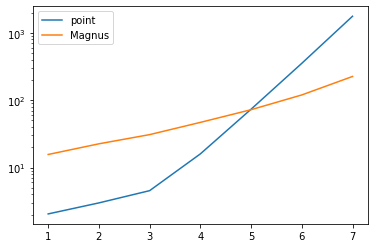

In [44]:
#plt.plot(N_variations, point_jit_times, label='point')
#plt.plot(N_variations, mag_jit_times, label='Magnus')
plt.plot(N_variations, point_jit_times, label='point')
plt.plot(N_variations, mag_jit_times, label='Magnus')
plt.yscale('log')
plt.legend()

average time including jit

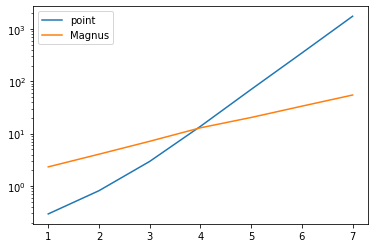

In [45]:
plt.plot(N_variations, point_ave_times, label='point')
plt.plot(N_variations, mag_ave_times, label='Magnus')
plt.yscale('log')
plt.legend()

average time not including jit time

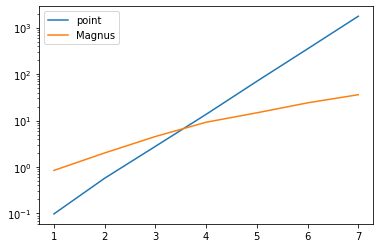

In [46]:
plt.plot(N_variations, point_ave_jitted_times, label='point')
plt.plot(N_variations, mag_ave_jitted_times, label='Magnus')
plt.yscale('log')
plt.legend()

# Running optimization with Magnus-based objective functions

In [12]:
from random import randint
from scipy.optimize import minimize
from time import time
from jax import random, config

def vec_value_and_grad(f, ctrl_shape):
    """ Given a function f returns a version of value_and_grad(f) that takes 1d arrays
    and returns 1d array gradients (for scipy minimize)
    """

    f_value_and_grad = value_and_grad(f)

    def vecf(x):
        val, grad = f_value_and_grad(x.reshape(ctrl_shape))
        return val, grad.real.flatten()

    return vecf

def updating_function(f, update_rate):
    """Print updates at each function call
    """

    # set up the call counter
    calls = 0
    time_taken = 0.

    # define the new function
    def upd_f(x):
        # give the function access to the call counter, and increment it
        # every call
        nonlocal calls
        nonlocal time_taken
        calls = calls + 1

        start = time()
        #compute f
        output = f(x)
        end = time()

        time_taken += end - start

        # if its time to give an update, report the update depending on the
        # format of the output of f
        if calls % update_rate == 0:
            val = None
            if type(output) == tuple:
                val = output[0]
            else:
                val = output

            print('Evaluation {}: obj = {}, time = {}'.format(str(calls), str(val), str(time_taken)))
            time_taken = 0.
        return output

    return upd_f

def find_pulse_bfgs(obj, ctrl_shape, initial_guess=None, update_rate=None,tol=0.):
    """ Runs bfgs algorithm from scipy minimize for a given objective, ctrl_shape
    and initial guess
    """

    mod_obj = jit(vec_value_and_grad(obj, ctrl_shape))

    if update_rate is not None:
        mod_obj = updating_function(mod_obj, update_rate)

    if initial_guess == None:
        key = randint(-10**5,10**5)
        initial_guess = random.uniform(random.PRNGKey(key), shape=ctrl_shape, minval=-1, maxval=1)

    # set the start time
    start = time()

    print('Optimizing pulse...')
    # run the optimization
    if tol != 0:
        result = minimize(mod_obj, initial_guess.flatten(), method='BFGS', jac=True, options={'disp': True},tol=tol)
    else:
        result = minimize(mod_obj, initial_guess.flatten(), method='BFGS', jac=True, options={'disp': True})
    # reshape the point the optimizer ends on to be the correct shape
    result.x = result.x.reshape(ctrl_shape)

    # record the end time and report the total time taken
    end = time()
    print('Total time taken: ' + str(end-start))

    return result

In [13]:
mag_obj_funcs = [lambda params: magnus_obj0(params, p0_vals),
                 lambda params: magnus_obj1(params, p0_vals, p1_vals),
                 lambda params: magnus_obj2(params, p0_vals, p1_vals, p2_vals),
                 lambda params: magnus_obj3(params, p0_vals, p1_vals, p2_vals, p3_vals),
                 lambda params: magnus_obj4(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals),
                 lambda params: magnus_obj5(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals),
                 lambda params: magnus_obj6(params, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, p6_vals)]

exact_obj_funcs = [lambda params: point_obj0(params, p0_vals),
                   lambda params: point_obj1(params, p0_vals, p1_vals)]

ctrl_shape = (2, leg_order+1)

In [20]:
# prepare an initial guess
guess = random.uniform(random.PRNGKey(11),shape=ctrl_shape, minval=-1, maxval=1)
print(guess)

[[ 0.5121181  -0.05975102 -0.90055784  0.69679124  0.16320247]
 [ 0.47334127  0.96164478  0.35713535  0.35439576  0.28126117]]


In [21]:
#1 variation
obj = mag_obj_funcs[0]
result0 =  find_pulse_bfgs(obj, ctrl_shape, initial_guess=guess, update_rate=10,tol=0.01)

Optimizing pulse...
Evaluation 10: obj = 0.1326007665589276, time = 17.565286874771118
Evaluation 20: obj = 0.04196224822900996, time = 0.0006175041198730469
Optimization terminated successfully.
         Current function value: 0.030974
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
Total time taken: 43.823610067367554


In [22]:
#1 variation, run the optimization using the exact-error based objective function
result0_ex =  find_pulse_bfgs(exact_obj_funcs[0], ctrl_shape, initial_guess=guess, update_rate=10,tol=0.01)

Optimizing pulse...
Evaluation 10: obj = 0.09482322264779247, time = 9.119730234146118
Optimization terminated successfully.
         Current function value: 0.035811
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Total time taken: 45.22459316253662


[[  7.51304128   7.43698254 -48.29599594  -0.48006661  -0.44491655]
 [  2.08135822   1.0698587    1.05090028   3.0237258   -0.15345103]]
[[  2.00662374   1.19774419 -13.5611861   -0.25615391   0.05156082]
 [  1.91962051   0.6109728    1.24330775   0.85064485  -0.6350828 ]]


/Users/fuhuilin/anaconda3/envs/qiskit_new/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/fuhuilin/anaconda3/envs/qiskit_new/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


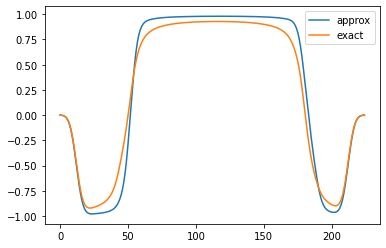

In [43]:
# Compare the pulses found by the 2 optimizations above
r0_0 = param_to_signal(result0.x)
r0_1 = param_to_signal(result0_ex.x)
plt.plot(r0_0[:,0],label='approx')
plt.plot(r0_1[:,0],label='exact')
plt.legend()

/Users/fuhuilin/anaconda3/envs/qiskit_new/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/fuhuilin/anaconda3/envs/qiskit_new/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


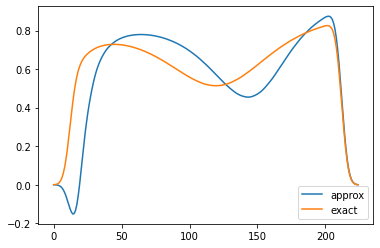

In [44]:
plt.plot(r0_0[:,1],label='approx')
plt.plot(r0_1[:,1],label='exact')
plt.legend()

In [30]:
# Evaluate the robustness of the pulse obtained with the approximate objective function

exact_err0 = point_obj0(result0.x, p0_vals, out = 1)

plt.plot(p0_vals, exact_err0)
plt.xlabel('Perturbation Magnitude')# unit?
plt.ylabel('Exact error')
plt.title("1 perturbation")

In [24]:
#2 variations
obj = mag_obj_funcs[1]
result1 = find_pulse_bfgs(obj, ctrl_shape, update_rate=10,tol=0.01)
#result1 = find_pulse_bfgs(obj, ctrl_shape,initial_guess=guess, update_rate=10,tol=0.01)

Optimizing pulse...
Evaluation 10: obj = 0.13758728755130334, time = 25.540122509002686
Evaluation 20: obj = 0.050582327655627424, time = 0.0006427764892578125
Optimization terminated successfully.
         Current function value: 0.041693
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
Total time taken: 84.19830799102783


In [24]:
# Evaluate and visualize the robustness of the pulse

exact_err1 = point_obj1(result1.x, p0_vals, p1_vals, out = 1)

import matplotlib as mpl

cell0 = cell_centered(p0_vals)
cell1 = cell_centered(p1_vals)
cmap = mpl.cm.Greys
norm = mpl.colors.Normalize(vmin=0., vmax=max(exact_err1))
exact_err1_reshape = exact_err1.reshape((5,5))
plt.pcolormesh(cell0, cell1, exact_err1_reshape, norm=norm, cmap=cmap)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),orientation='horizontal',label="Exact error")
plt.title("2 perturbations")

In [26]:
#3 variations
obj = mag_obj_funcs[2]
result2 = find_pulse_bfgs(obj, ctrl_shape, update_rate=10,tol=0.01)

Optimizing pulse...
Evaluation 10: obj = 0.7336889509786674, time = 36.056445360183716
Evaluation 20: obj = 0.08467806089848526, time = 0.0020248889923095703
Evaluation 30: obj = 0.04607600225006023, time = 0.0017571449279785156
Optimization terminated successfully.
         Current function value: 0.046076
         Iterations: 20
         Function evaluations: 30
         Gradient evaluations: 30
Total time taken: 180.40686702728271


In [30]:
exact_err2 = point_obj2(result2.x, p0_vals, p1_vals, p2_vals, out = 1)
exact_err2_reshape = exact_err2.reshape((5,5,5))
print("Center:",exact_err2_reshape[2,2,2])
avg_err1 = 0.
count1 = 0
avg_err2 = 0.
count2 = 0
for i in range(5):
    for j in range(5):
        for k in range(5):
            max_d = max(abs(i-2),abs(j-2),abs(k-2))
            if max_d == 1:
                avg_err1 += exact_err2_reshape[i,j,k]
                count1 += 1
            elif max_d == 2:
                avg_err2 += exact_err2_reshape[i,j,k]
                count2 += 1
avg_err1 /= count1
avg_err2 /= count2
print("Average error at points with max coordinate-wise distance 1 from center:",avg_err1)
print("Average error at points with max coordinate-wise distance 2 from center:",avg_err2)

Center: 0.014025969810546823
Average error at points with max distance 1 from center: 0.025704336221938302
Average error at points with max distance 2 from center: 0.08568735832103302


In [31]:
#4 variations
obj = mag_obj_funcs[3]
result3 =  find_pulse_bfgs(obj, ctrl_shape, update_rate=10,tol=0.01)

Optimizing pulse...
Evaluation 10: obj = 0.5904414363082325, time = 53.28021574020386
Evaluation 20: obj = 0.5426898889397176, time = 0.0036253929138183594
Evaluation 30: obj = 0.5200836720511435, time = 0.003826618194580078
Optimization terminated successfully.
         Current function value: 0.503049
         Iterations: 29
         Function evaluations: 34
         Gradient evaluations: 34
Total time taken: 344.7638430595398


In [32]:
exact_err3 = point_obj3(result3.x, p0_vals, p1_vals, p2_vals, p3_vals, out = 1)
exact_err3_reshape = exact_err3.reshape((5,5,5,5))
print("Center:",exact_err3_reshape[2,2,2,2])
avg_err1 = 0.
count1 = 0
avg_err2 = 0.
count2 = 0
for i1 in range(5):
    for i2 in range(5):
        for i3 in range(5):
            for i4 in range(5):
                max_d = max(abs(i1-2),abs(i2-2),abs(i3-2),abs(i4-2))
                if max_d == 1:
                    avg_err1 += exact_err3_reshape[i1,i2,i3,i4]
                    count1 += 1
                elif max_d == 2:
                    avg_err2 += exact_err3_reshape[i1,i2,i3,i4]
                    count2 += 1
avg_err1 /= count1
avg_err2 /= count2
print("Average error at points with max distance 1 from center:",avg_err1)
print("Average error at points with max distance 2 from center:",avg_err2)

Center: 0.12087878353892323
Average error at points with max distance 1 from center: 0.6247607958860442
Average error at points with max distance 2 from center: 0.6239117863184627


In [33]:
#5 variations
obj = mag_obj_funcs[4]
result4 =  find_pulse_bfgs(obj, ctrl_shape, update_rate=10,tol=0.01)

Optimizing pulse...
Evaluation 10: obj = 0.6659980633583727, time = 86.38551378250122


KeyboardInterrupt: 

In [ ]:
exact_err4 = point_obj4(result4.x, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, out = 1)
exact_err4_reshape = exact_err4.reshape((5,5,5,5,5))
print("Center:",exact_err4_reshape[2,2,2,2,2])
avg_err1 = 0.
count1 = 0
avg_err2 = 0.
count2 = 0
for i1 in range(5):
    for i2 in range(5):
        for i3 in range(5):
            for i4 in range(5):
                for i5 in range(5):
                    max_d = max(abs(i1-2),abs(i2-2),abs(i3-2),abs(i4-2),abs(i5-2))
                    if max_d == 1:
                        avg_err1 += exact_err3_reshape[i1,i2,i3,i4,i5]
                        count1 += 1
                    elif max_d == 2:
                        avg_err2 += exact_err3_reshape[i1,i2,i3,i4,i5]
                        count2 += 1
avg_err1 /= count1
avg_err2 /= count2
print("Average error at points with max distance 1 from center:",avg_err1)
print("Average error at points with max distance 2 from center:",avg_err2)

In [67]:
#6 variations
obj = mag_obj_funcs[5]
result5 =  find_pulse_bfgs(obj, ctrl_shape, update_rate=10,tol=0.01)

Optimizing pulse...
Evaluation 10: obj = 0.46181984609653737, time = 146.2245044708252
Evaluation 20: obj = 0.4549279713564349, time = 0.0011475086212158203
Optimization terminated successfully.
         Current function value: 0.453407
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
Total time taken: 793.5342440605164


In [ ]:
exact_err5 = point_obj5(result5.x, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, out = 1)
exact_err5_reshape = exact_err5.reshape((5,5,5,5,5,5))
print("Center:",exact_err5_reshape[2,2,2,2,2,2])
avg_err1 = 0.
count1 = 0
avg_err2 = 0.
count2 = 0
for i1 in range(5):
    for i2 in range(5):
        for i3 in range(5):
            for i4 in range(5):
                for i5 in range(5):
                    for i6 in range(5):
                        max_d = max(abs(i1-2),abs(i2-2),abs(i3-2),abs(i4-2),abs(i5-2),abs(i6-2))
                        if max_d == 1:
                            avg_err1 += exact_err3_reshape[i1,i2,i3,i4,i5,i6]
                            count1 += 1
                        elif max_d == 2:
                            avg_err2 += exact_err3_reshape[i1,i2,i3,i4,i5,i6]
                            count2 += 1
avg_err1 /= count1
avg_err2 /= count2
print("Average error at points with max distance 1 from center:",avg_err1)
print("Average error at points with max distance 2 from center:",avg_err2)

In [68]:
#7 variations  
obj = mag_obj_funcs[6]
result6 =  find_pulse_bfgs(obj, ctrl_shape, update_rate=10,tol=0.01)

Optimizing pulse...
Evaluation 10: obj = 0.45296321123456895, time = 271.8437638282776
Optimization terminated successfully.
         Current function value: 0.452646
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
Total time taken: 790.102374792099


In [ ]:
exact_err6 = point_obj6(result6.x, p0_vals, p1_vals, p2_vals, p3_vals, p4_vals, p5_vals, out = 1)
exact_err6_reshape = exact_err6.reshape((5,5,5,5,5,5,5))
print("Center:",exact_err6_reshape[2,2,2,2,2,2,2])
avg_err1 = 0.
count1 = 0
avg_err2 = 0.
count2 = 0
for i1 in range(5):
    for i2 in range(5):
        for i3 in range(5):
            for i4 in range(5):
                for i5 in range(5):
                    for i6 in range(5):
                        for i7 in range(5):
                            max_d = max(abs(i1-2),abs(i2-2),abs(i3-2),abs(i4-2),abs(i5-2),abs(i6-2),abs(i7-2))
                            if max_d == 1:
                                avg_err1 += exact_err3_reshape[i1,i2,i3,i4,i5,i6,i7]
                                count1 += 1
                            elif max_d == 2:
                                avg_err2 += exact_err3_reshape[i1,i2,i3,i4,i5,i6,i7]
                                count2 += 1
avg_err1 /= count1
avg_err2 /= count2
print("Average error at points with max distance 1 from center:",avg_err1)
print("Average error at points with max distance 2 from center:",avg_err2)